In [225]:
import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, GroupShuffleSplit
from sklearn.ensemble import ExtraTreesClassifier

from scipy.stats import wilcoxon

In [57]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'

all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']

# path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [58]:
df_markers = pd.DataFrame()

for i,v in enumerate(all_participants): 
    participant = v
    
    folder = path + participant +'/'
    
    df_ = pd.read_csv(folder+ participant + '_' + epoch_type + '_all_marker.csv', index_col = 0)
    df_['participant'] = i
    df_markers = df_markers.append(df_)
    
df_markers.to_csv('all_markers.csv')

# Univariate analysis: On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [213]:
df_mind = (
    df_markers
    .query("probe == 'PC'")
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
    .query("mind != 'sMW'") #if you want to test against just one of the mw
    .drop(['participant', 'probe', 'mind'], axis = 1) # drop mind or mind2 also
)

AUC wSMI = 0.5185755162013765
AUC p_e = 0.4982445286520764
AUC k = 0.48337328899543736
AUC b = 0.47190472507926695
AUC b_n = 0.4428273142061712
AUC g = 0.5059701492537313
AUC g_n = 0.507424019797386
AUC t = 0.5283040754775346
AUC t_n = 0.563026834738226
AUC d = 0.4825999535998763
AUC d_n = 0.4729796612790968
AUC a_n = 0.49499651999072
AUC a = 0.4967442579846879
AUC CNV = 0.49222024592065583
AUC P1 = 0.546763591369577
AUC P3a = 0.4988245301987472
AUC P3b = 0.5417446446523857


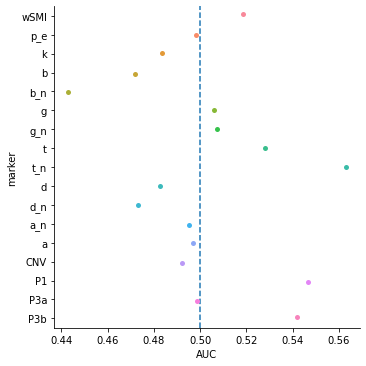

In [63]:
markers = df_mind.drop('mind2', axis = 1).columns

AUC = []
for i in markers:
    auc = roc_auc_score(df_mind['mind2'], df_mind[i])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.526966205243214
AUC p_e = 0.5382337019565384
AUC k = 0.4379166344443586
AUC b = 0.47220632588353567
AUC b_n = 0.44304384811692826
AUC g = 0.45673961797231455
AUC g_n = 0.5723223261928698
AUC t = 0.5323176861804965
AUC t_n = 0.4407315752842007
AUC d = 0.512052432139819
AUC d_n = 0.5480395947722527
AUC a_n = 0.5377001005336014
AUC a = 0.5467481246616658
AUC CNV = 0.5310339494238651
AUC P1 = 0.4375415667775113
AUC P3a = 0.5351016936045162
AUC P3b = 0.5587425566468177
Index(['mw', 'on-task'], dtype='object')


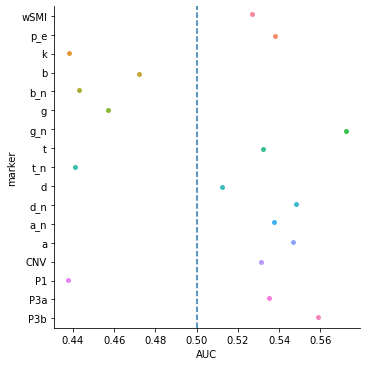

In [64]:
markers = df_mind.drop('mind2', axis = 1).columns

AUC = []
for i in markers:
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    svc = SVC(probability=True)
    svc.fit(X, y)
    y_proba = svc.predict_proba(X)
    auc = roc_auc_score(y, y_proba[:,0])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])

print(label)
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

In [214]:
markers = df_mind.drop('mind2', axis = 1).columns

AUC = pd.DataFrame()
for i in markers:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
    pipe = Pipeline(steps)
    
#     parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
#     grid = GridSearchCV(pipe, param_grid=parameteres, cv=5, n_jobs = -1)
#     grid.fit(X, y)      
#     steps = [('scaler', StandardScaler()), ('SVM', SVC(C =grid.best_params_['SVM__C'], gamma =grid.best_params_['SVM__gamma'], probability=True))]
#     pipe = Pipeline(steps)
    
    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
        random_state=42)

    aucs = cross_val_score(
    X=X, y=y, estimator=pipe,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')
    
    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.4880491937227267
AUC p_e = 0.4839484862182399
AUC k = 0.522394897218872
AUC b = 0.5229458875065243
AUC b_n = 0.504254613574821
AUC g = 0.547656886309955
AUC g_n = 0.5198785252035014
AUC t = 0.49557408318111945
AUC t_n = 0.5013372640224412
AUC d = 0.5007014875837466
AUC d_n = 0.5345495117956961
AUC a_n = 0.4959045261183612
AUC a = 0.48487944447324816
AUC CNV = 0.4766314857015777
AUC P1 = 0.48526928083247234
AUC P3a = 0.4879562803633856
AUC P3b = 0.5006255120437038


In [221]:
markers = df_mind.drop('mind2', axis = 1).columns

n_estimators = 2000
AUC = pd.DataFrame()
for i in markers:
    
    y, label = pd.factorize(df_mind['mind2'])
    X = df_mind[i].astype('float32').values.reshape(-1,1)
    
    doc_forest = make_pipeline(
        RobustScaler(),
        ExtraTreesClassifier(
            n_estimators=n_estimators, max_features=1, criterion='entropy',
            max_depth=4, random_state=42, class_weight='balanced'))

    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                           random_state=42)

    aucs = cross_val_score(
        X=X, y=y, estimator=doc_forest,
        scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')

AUC wSMI = 0.4820273243897983
AUC p_e = 0.5085107171050414
AUC k = 0.5768869036975027
AUC b = 0.5192308090064183
AUC b_n = 0.5572552687561912
AUC g = 0.5350697902162674
AUC g_n = 0.579103508189301
AUC t = 0.48381255844118726
AUC t_n = 0.5076050699891339
AUC d = 0.4797993551142368
AUC d_n = 0.5535039856753514
AUC a_n = 0.49200934615986663
AUC a = 0.5012866448613622
AUC CNV = 0.4743124149699118
AUC P1 = 0.5018387375598529
AUC P3a = 0.48120646099961056
AUC P3b = 0.5251134002726138


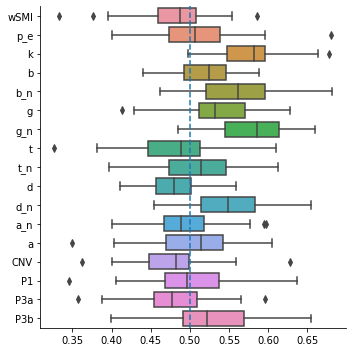

In [222]:
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

# Univariate analysis: dMW Vs sMW
This will be only performed in SC as they have more trials

In [66]:
df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .drop(['participant', 'probe'], axis = 1)
)

AUC wSMI = 0.48811850136305523
AUC p_e = 0.4137260172940856
AUC k = 0.5191409305996408
AUC b = 0.42768397798433266
AUC b_n = 0.490851504530306
AUC g = 0.47921383940418466
AUC g_n = 0.5319525291480129
AUC t = 0.457524719376062
AUC t_n = 0.504772416312548
AUC d = 0.48966163146158803
AUC d_n = 0.5619276805315743
AUC a_n = 0.4289832745720421
AUC a = 0.4127317279955334
AUC CNV = 0.5166944102675448
AUC P1 = 0.5171234883183932
AUC P3a = 0.5474432807066519
AUC P3b = 0.5199667766071472


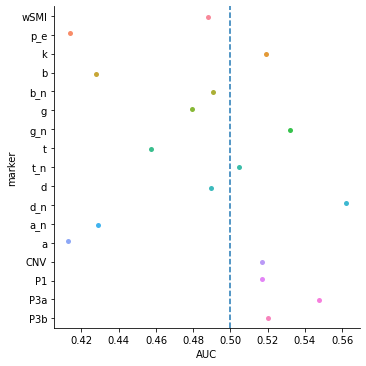

In [224]:
markers = df_mw.drop('mind', axis = 1).columns

AUC = []
for i in markers:
    auc = roc_auc_score(df_mw['mind'], df_mw[i])
    print(f'AUC {i} = {auc}')
    AUC.append([i, auc])
df_auc = pd.DataFrame(AUC, columns = ['marker', 'AUC'])

sns.catplot(x = 'AUC', y = 'marker', data = df_auc, orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

AUC wSMI = 0.5143342660580114
AUC p_e = 0.5785466072763985
AUC k = 0.5391837358480911
AUC b = 0.6046043693914409
AUC b_n = 0.5318217858023713
AUC g = 0.5548606716478324
AUC g_n = 0.5546905795405731
AUC t = 0.5341408527832584
AUC t_n = 0.5182317507856701
AUC d = 0.4911585068841249
AUC d_n = 0.5534022658043775
AUC a_n = 0.5674706896241056
AUC a = 0.5871223412772264
AUC CNV = 0.5317990013227547
AUC P1 = 0.5051494898105324
AUC P3a = 0.5322790302695809
AUC P3b = 0.5183271682774749


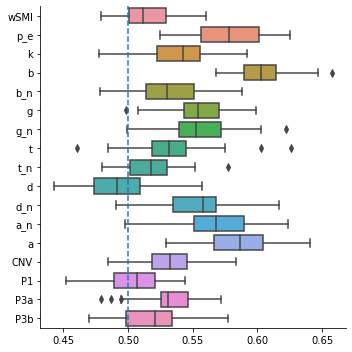

In [223]:
markers = df_mw.drop('mind', axis = 1).columns

AUC = pd.DataFrame()
for i in markers:
    
    y, label = pd.factorize(df_mw['mind'])
    X = df_mw[i].astype('float32').values.reshape(-1,1)
    
    steps = [('scaler', StandardScaler()), ('SVM', SVC(probability=True))]
    pipe = Pipeline(steps)
    
#     parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}
#     grid = GridSearchCV(pipe, param_grid=parameteres, cv=5, n_jobs = -1)
#     grid.fit(X, y)      
#     steps = [('scaler', StandardScaler()), ('SVM', SVC(C =grid.best_params_['SVM__C'], gamma =grid.best_params_['SVM__gamma'], probability=True))]
#     pipe = Pipeline(steps)
    
    cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
        random_state=42)

    aucs = cross_val_score(
    X=X, y=y, estimator=pipe,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

    AUC[i] = aucs

#     print(label)
    print(f'AUC {i} = {np.mean(aucs)}')
    
    
sns.catplot(data = AUC, kind = 'box', orient = 'h')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()